##  実験目標
- 一局を通して現れる異常な行動を画像ベースで取得する

## 実験手順
- 棋譜から評価値を読み込む -> ok
- 「指し手から次の指し手」までの間隔を画像ベースで把握する -> ok
- 初手から10手をニュートラルの姿勢とし、異常検知をして画像を収集する -> ok
    - 初手から10手の画像とpose抽出画像をそれぞれaddWeightedで重ねる -> ok
    - 2種類の画像を基準に異常な行動画像を抽出

## モジュールの読み込み


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import os
import sys

# 特徴量抽出
from DeNAPose.pose_detector import PoseDetector, draw_person_pose

## 棋譜から評価値を読み込む

In [2]:
!ls ../output

000000.png  000240.png	000480.png  000720.png	000960.png
000030.png  000270.png	000510.png  000750.png	000990.png
000060.png  000300.png	000540.png  000780.png	img_orig_mean.png
000090.png  000330.png	000570.png  000810.png	img_skel_mean.png
000120.png  000360.png	000600.png  000840.png	output.mp4
000150.png  000390.png	000630.png  000870.png
000180.png  000420.png	000660.png  000900.png
000210.png  000450.png	000690.png  000930.png


In [3]:
with open("../data/kif/AbemaTV_Tournament_Final1_analized.kif", encoding="utf-8") as f:
    kif = f.readlines()

In [4]:
# 改行ごとにリストになっている
kif

['開始日時：2018/10/12 18:47:32\n',
 '終了日時：2018/10/12 18:57:43\n',
 '表題：AbemaTVトーナメント_決勝_藤井七段vs佐々木勇気六段_1局目\n',
 '棋戦：AbemaTVトーナメント\n',
 '持ち時間：各持ち時間20分,秒読み10秒\n',
 '手合割：平手\n',
 '先手：佐々木勇気\n',
 '後手：藤井聡太\n',
 '手数----指手---------消費時間--\n',
 '*** 棋譜解析エンジン:Apery\n',
 '   1 ２六歩(27)   ( 0:02/00:00:02)\n',
 '*## 0 ▲２六歩△８四歩/## 0 ▲２六歩△８四歩\n',
 '   2 ８四歩(83)   ( 0:06/00:00:06)\n',
 '*## 0 △８四歩▲７六歩/## 0 △８四歩▲７六歩\n',
 '   3 ７六歩(77)   ( 0:01/00:00:03)\n',
 '*## 0 ▲７六歩△８五歩/## 0 ▲７六歩△８五歩\n',
 '   4 ３二金(41)   ( 0:01/00:00:07)\n',
 '*## 0 △３二金▲７八金/## 0 △８五歩▲７七角\n',
 '   5 ７八金(69)   ( 0:01/00:00:04)\n',
 '*## 0 ▲７八金△８五歩/## 0 ▲７八金△８五歩\n',
 '   6 ８五歩(84)   ( 0:01/00:00:08)\n',
 '*## 0 △８五歩▲７七角/## 0 △８五歩▲７七角\n',
 '   7 ７七角(88)   ( 0:01/00:00:05)\n',
 '*## 0 ▲７七角△３四歩/## 0 ▲７七角△３四歩\n',
 '   8 ３四歩(33)   ( 0:10/00:00:18)\n',
 '*## 0 △３四歩▲８八銀/## 0 △３四歩▲８八銀\n',
 '   9 ６八銀(79)   ( 0:01/00:00:06)\n',
 '*## 120 ▲６八銀△４四歩▲４八銀△４二銀▲３六歩△４一王▲４六歩△６二銀▲４七銀△７四歩▲６六歩△５二金▲６七銀△７三銀▲５八金△５四歩▲４八玉△４三銀▲３七桂△３一角▲２九飛/## 0 ▲８八銀△６四歩\n',
 '  10 ７七角成(

In [5]:
# 評価値を含む行を参照
shogi_df = pd.DataFrame([int(k.split(" ")[1]) for k in kif if "*##" in k], columns=["score"])

In [6]:
# 評価値を300基準で切り分ける
shogi_df['score_label'] = shogi_df["score"].map(lambda x: x//300)

In [7]:
shogi_df["hand_number"]

,score,score_label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,120,0
9,0,0


In [8]:
shogi_df.iloc[0]["score"]

0

In [9]:
shogi_df.tail()

,score,score_label
92,1535,5
93,1720,5
94,1933,6
95,99999,333
96,99999,333


## 対局動画から姿勢を取る

In [2]:
cap = cv2.VideoCapture("/media/nvidia/JetsonTX2SSD240/data/AbemaTV_Tournament_Final1.mp4")

In [3]:
pose_detector = PoseDetector("posenet", "../utils/DeNAPose/models/coco_posenet.npz", device=0)

Loading the model...


### 姿勢抽出領域の指定

In [57]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 10000)
frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)

In [58]:
# 手動による前処理によって大きさはFullHDに統一
frame.shape

(1080, 1920, 3)

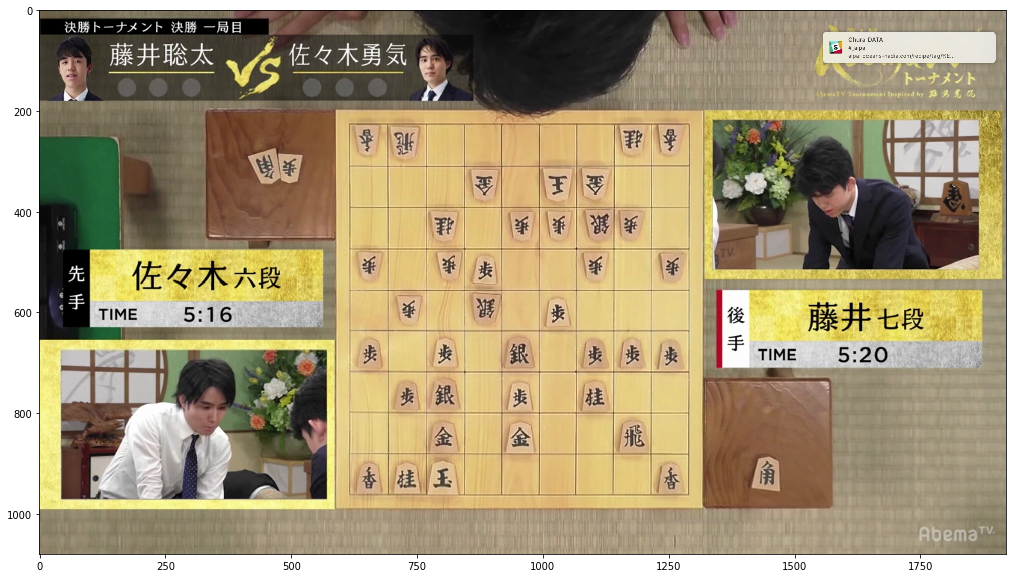

In [59]:
plt.figure(figsize=(18, 10))
plt.imshow(frame)

In [60]:
# ひとまず今回の決勝戦1回目の対局については藤井先生が後手のため後手領域をハードコーディングで絞る
pose_rect = frame[220:510, 1340:1860].copy()

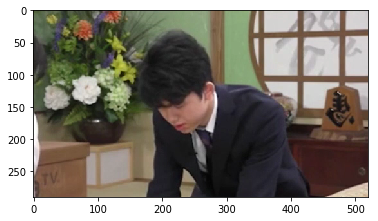

In [61]:
plt.imshow(pose_rect)

In [9]:
a = np.array([1,2,3,4,6])

In [10]:
a[np.array([1,2])]

array([2, 3])

In [11]:
pose_keypoints, _ = pose_detector(pose_rect)

/home/nvidia/Desktop/Research/utils/DeNAPose/pose_detector.py:147: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  paf_in_edge = np.hstack([paf[0][np.hsplit(integ_points, 2)], paf[1][np.hsplit(integ_points, 2)]])


In [12]:
np.where(_ > 5)[0]

array([0])

In [13]:
img_skelton = draw_person_pose(pose_rect.copy(), pose_keypoints[np.where(_ > 5)])

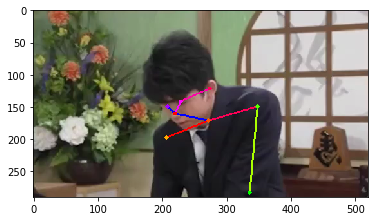

In [14]:
plt.imshow(img_skelton)

In [15]:
draw_person_pose(pose_rect.copy(), pose_detector(pose_rect)[0])

/home/nvidia/Desktop/Research/utils/DeNAPose/pose_detector.py:147: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  paf_in_edge = np.hstack([paf[0][np.hsplit(integ_points, 2)], paf[1][np.hsplit(integ_points, 2)]])


array([[[103, 102,  73],
        [104, 103,  74],
        [103, 104,  72],
        ...,
        [189, 175, 185],
        [189, 175, 182],
        [190, 176, 183]],

       [[103, 102,  73],
        [104, 103,  74],
        [103, 104,  72],
        ...,
        [190, 176, 186],
        [190, 176, 183],
        [190, 176, 183]],

       [[102, 103,  73],
        [103, 104,  74],
        [100, 105,  72],
        ...,
        [189, 178, 183],
        [190, 176, 181],
        [190, 176, 181]],

       ...,

       [[ 32,  24,  25],
        [ 32,  24,  25],
        [ 33,  25,  26],
        ...,
        [ 28,  23,  23],
        [ 30,  24,  24],
        [ 31,  25,  25]],

       [[ 31,  23,  24],
        [ 31,  23,  24],
        [ 31,  23,  24],
        ...,
        [ 26,  20,  20],
        [ 31,  25,  25],
        [ 42,  37,  37]],

       [[ 31,  23,  24],
        [ 31,  23,  24],
        [ 31,  23,  24],
        ...,
        [ 24,  18,  18],
        [ 35,  30,  30],
        [ 60,  54,  54]]

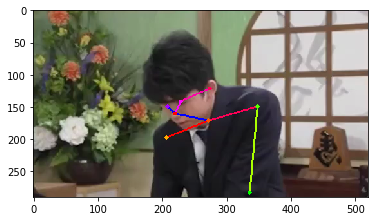

In [22]:
plt.imshow(img_skelton)

In [23]:
pose_keypoints

array([[[220.27777778, 160.40625   ,   2.        ],
        [271.73611111, 171.28125   ,   2.        ],
        [206.73611111, 196.65625   ,   2.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [347.56944444, 148.625     ,   2.        ],
        [335.83333333, 282.75      ,   2.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [207.63888889, 148.625     ,   2.        ],
        [229.30555556, 141.375     ,   2.        ],
        [  0.        ,   0.        ,   0.        ],
        [273.54166667, 121.4375    ,   2.        ]]])

### 指し手から次の指し手までの間隔を取得する

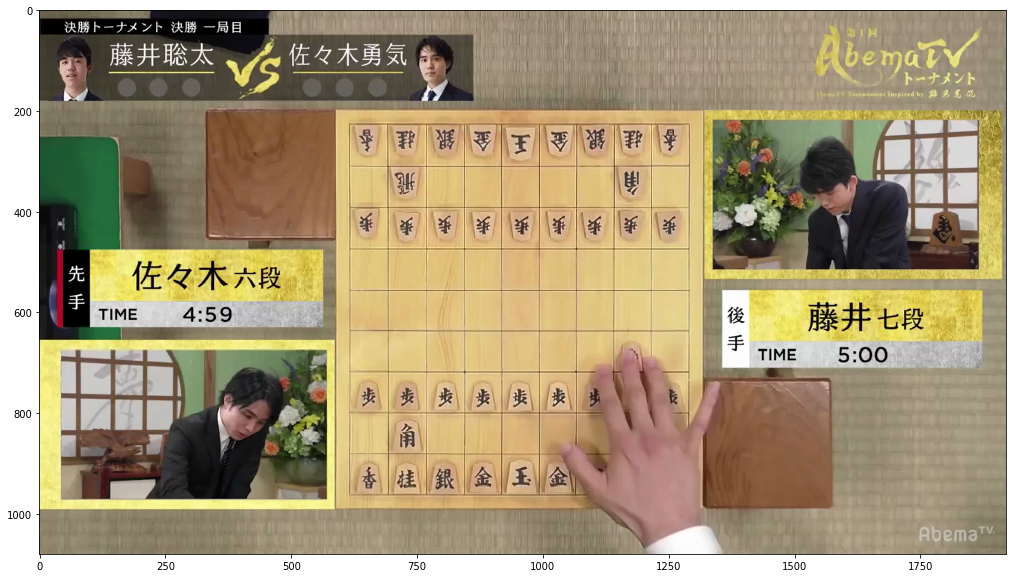

In [24]:
plt.figure(figsize=(18, 10))
plt.imshow(frame)

先手と後手の赤いマークを基準にして変わったかどうかを判定する

In [51]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 5000)
frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
black_flag_rect = frame[475:630, 35:45].copy()

In [50]:
pose_skel_rect = draw_person_pose(np.full_like(pose_rect, 255), pose_detector(pose_rect)[0])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-4b0bd34535ba>", line 1, in <module>
    pose_skel_rect = draw_person_pose(np.full_like(pose_rect, 255), pose_detector(black_flag_rect)[0])
  File "/home/nvidia/Desktop/Research/utils/DeNAPose/pose_detector.py", line 502, in __call__
    heatmaps = F.resize_images(h2s[-1], (map_h, map_w)).data[0]
  File "/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/chainer/functions/array/resize_images.py", line 159, in resize_images
    return ResizeImages(output_shape).apply((x,))[0]
  File "/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/chainer/function_node.py", line 258, in apply
    outputs = self.forward(in_data)
  File "/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/chainer/functions/array/resize_images.py"

KeyboardInterrupt: 

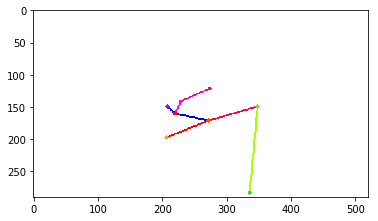

In [45]:
plt.imshow(pose_skel_rect)

In [ ]:
mean_flag = True
flag_prev, flag_next = True, True
time_idx, hand_idx = 0, 0
threshold = 10
pose_thresh = 5

pose_frames, hand_labels, times = [], [], []

for i in tqdm(range(10000)):
    cap.set(cv2.CAP_PROP_POS_FRAMES, 6*i)
    frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
    pose_rect = frame[220:510, 1340:1860].copy()
    
    pose_frames.append(pose_rect)
    hand_labels.append(hand_idx)
    
    black_flag_rect = frame[475:630, 35:45].copy()
    white_flag_rect = frame[555:710, 1345:1355].copy()
    
    # 先手と後手が入れ替わったら
    if (flag_prev ^ flag_next) or i==0:
        b_mean_prev = np.mean(black_flag_rect, axis=(0, 1))
        w_mean_prev = np.mean(white_flag_rect, axis=(0, 1)) 
        flag_prev = flag_next
        continue
    
    # 先手もしくは後手が指し手を考慮中の場合
    else:
        b_mean_next = np.mean(black_flag_rect, axis=(0, 1))
        w_mean_next = np.mean(white_flag_rect, axis=(0, 1))
        
        if flag_prev:
            state = np.mean(b_mean_next - b_mean_prev)
            b_mean_prev = b_mean_next
        else:
            state = np.mean(w_mean_next - w_mean_prev)
            w_mean_prev = w_mean_next 
            
        if abs(state) > threshold:
            flag_next = not flag_next
            print("{}の指し手までの時間: {}s".format(["先手", "後手"][~flag_prev], (i - time_idx) * 0.1))
            times.append((i - time_idx) * 0.1)
            time_idx = i
            hand_idx += 1
    
    # 10手指したらこれまでの画像の平均的な画像をオリジナルとスケルトンの2つで作成
    if (hand_idx == threshold) and mean_flag:
        for idx, img in enumerate(tqdm(pose_frames)):
            if idx==0:
                img_prev_orig = img
                
                pose_keypoints, scores = pose_detector(img)
                img_prev_skel = draw_person_pose(np.full_like(img, 255), pose_keypoints[np.where(scores > pose_thresh)])
                continue
            else:
                img_next_orig = img
                
                pose_keypoints, scores = pose_detector(img)
                img_next_skel = draw_person_pose(np.full_like(img, 255), pose_keypoints[np.where(scores > pose_thresh)])
                
                if idx==1:
                    img_orig_mean = cv2.addWeighted(img_prev_orig, 1 - (1/(idx+1)), img_next_orig, 1/(idx+1), 0)
                    img_skel_mean = cv2.addWeighted(img_prev_skel, 1 - (1/(idx+1)), img_next_skel, 1/(idx+1), 0)
                else:
                    img_orig_mean = cv2.addWeighted(img_orig_mean, 1 - (1/(idx+1)), img_next_orig, 1/(idx+1), 0)
                    img_skel_mean = cv2.addWeighted(img_skel_mean, 1 - (1/(idx+1)), img_next_skel, 1/(idx+1), 0)
                
        cv2.imwrite("../output/img_orig_mean.png", cv2.cvtColor(img_orig_mean, cv2.COLOR_RGB2BGR))
        cv2.imwrite("../output/img_skel_mean.png", cv2.cvtColor(img_skel_mean, cv2.COLOR_RGB2BGR))
        mean_flag = False

先手の指し手までの時間: 2.6s
後手の指し手までの時間: 1.9000000000000001s
先手の指し手までの時間: 3.1s
後手の指し手までの時間: 1.5s
先手の指し手までの時間: 2.8000000000000003s
後手の指し手までの時間: 2.5s
先手の指し手までの時間: 3.9000000000000004s
後手の指し手までの時間: 1.9000000000000001s
先手の指し手までの時間: 2.8000000000000003s
後手の指し手までの時間: 3.6s


/home/nvidia/Desktop/Research/utils/DeNAPose/pose_detector.py:147: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  paf_in_edge = np.hstack([paf[0][np.hsplit(integ_points, 2)], paf[1][np.hsplit(integ_points, 2)]])


先手の指し手までの時間: 3.0s
後手の指し手までの時間: 1.5s
先手の指し手までの時間: 2.8000000000000003s
後手の指し手までの時間: 1.9000000000000001s
先手の指し手までの時間: 3.5s
後手の指し手までの時間: 1.8s
先手の指し手までの時間: 2.9000000000000004s
後手の指し手までの時間: 1.7000000000000002s
先手の指し手までの時間: 9.4s
後手の指し手までの時間: 1.7000000000000002s
先手の指し手までの時間: 2.6s
後手の指し手までの時間: 1.9000000000000001s
先手の指し手までの時間: 7.6000000000000005s
後手の指し手までの時間: 2.0s
先手の指し手までの時間: 2.6s
後手の指し手までの時間: 2.3000000000000003s
先手の指し手までの時間: 7.2s
後手の指し手までの時間: 2.4000000000000004s
先手の指し手までの時間: 10.100000000000001s
後手の指し手までの時間: 1.9000000000000001s
先手の指し手までの時間: 4.1000000000000005s
後手の指し手までの時間: 2.1s
先手の指し手までの時間: 2.2s
後手の指し手までの時間: 2.0s
先手の指し手までの時間: 3.8000000000000003s
後手の指し手までの時間: 2.9000000000000004s
先手の指し手までの時間: 2.5s
後手の指し手までの時間: 2.9000000000000004s
先手の指し手までの時間: 2.4000000000000004s
後手の指し手までの時間: 10.600000000000001s
先手の指し手までの時間: 4.3s
後手の指し手までの時間: 49.800000000000004s
先手の指し手までの時間: 12.200000000000001s
後手の指し手までの時間: 32.4s
先手の指し手までの時間: 2.7s
後手の指し手までの時間: 27.5s
先手の指し手までの時間: 40.1s
後手の指し手までの時間: 15.200000000000001s
先手の指し手までの時間: 

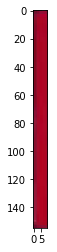

In [202]:
plt.imshow(black_flag_rect)

In [244]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 1200)
frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
white_flag_rect = frame[555:710, 1345:1355].copy()

In [238]:
np.mean(white_flag_rect, axis=(0, 1))

array([165.49935484,  17.17419355,  40.53032258])

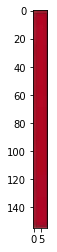

In [206]:
plt.imshow(white_flag_rect)

## ニュートラルな画像と現時点の画像との比較
`perceptual hash`という画像をハッシュ化して比較する方法があるのでそれを使ってみる

In [62]:
import imagehash
from PIL import Image, ImageFile

In [63]:
pose_skel_rect = draw_person_pose(np.full_like(pose_rect, 255), pose_detector(pose_rect)[0])

/home/nvidia/Desktop/Research/utils/DeNAPose/pose_detector.py:147: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  paf_in_edge = np.hstack([paf[0][np.hsplit(integ_points, 2)], paf[1][np.hsplit(integ_points, 2)]])


In [64]:
neutral_orig_hash = imagehash.phash(Image.fromarray(np.uint8(pose_rect)))

In [65]:
neutral_skel_hash = imagehash.phash(Image.fromarray(np.uint8(pose_skel_rect)))

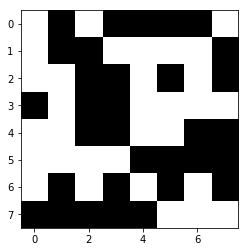

In [66]:
plt.imshow(np.asarray(neutral_orig_hash.hash), cmap="gray")

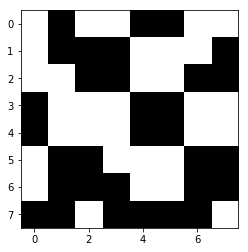

In [67]:
plt.imshow(np.asarray(neutral_skel_hash.hash), cmap="gray")

TypeError: Image data cannot be converted to float

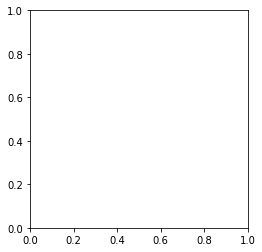

In [21]:
plt.imshow(neutral_or)

In [78]:
def compare_plot(imgs, labels, cmaps=None):
    """
    複数画像を比較して出力する際に使用
    
    imgs : 複数画像を含んだリスト
    labels : 画像のラベルを含んだリスト
    cmaps : 画像の出力形式を含んだリスト(チャンネルが1の際に使用)
    """
    fig, ax = plt.subplots(1, len(labels), figsize=(6*len(labels),6))

    for i, im in enumerate(imgs):
        if len(im.shape) == 3:
            ax[i].imshow(im)
        else:
            ax[i].imshow(im, cmap=cmaps[i])
        ax[i].set_title(labels[i])
    plt.show()

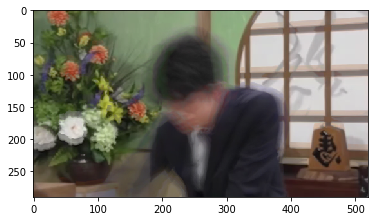

In [3]:
img_orig_mean = cv2.cvtColor(cv2.imread("../output/img_orig_mean.png"), cv2.COLOR_BGR2RGB)
plt.imshow(img_orig_mean)

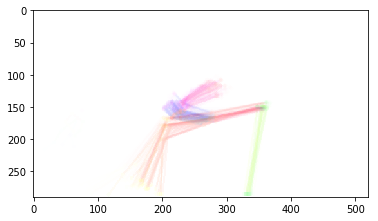

In [5]:
img_skel_mean = cv2.cvtColor(cv2.imread("../output/img_skel_mean.png"), cv2.COLOR_BGR2RGB)
plt.imshow(img_skel_mean)

In [83]:
# 11手目ぐらいで実行
cap.set(cv2.CAP_PROP_POS_FRAMES, 2000)
frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
pose_rect = frame[220:510, 1340:1860].copy()

In [84]:
neutral_hash = imagehash.phash(Image.fromarray(np.uint8(img_orig_mean)))
now_hash = imagehash.phash(Image.fromarray(np.uint8(pose_rect)))

In [85]:
neutral_hash - now_hash

12

In [86]:
neutral_hash = imagehash.phash(Image.fromarray(np.uint8(img_skel_mean)))

pose_keypoints, scores = pose_detector(pose_rect)
img_skel = draw_person_pose(np.full_like(pose_rect, 255), pose_keypoints[np.where(scores > 5)])

now_hash = imagehash.phash(Image.fromarray(np.uint8(img_skel)))

/home/nvidia/Desktop/Research/utils/DeNAPose/pose_detector.py:147: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  paf_in_edge = np.hstack([paf[0][np.hsplit(integ_points, 2)], paf[1][np.hsplit(integ_points, 2)]])


In [87]:
neutral_hash - now_hash

4

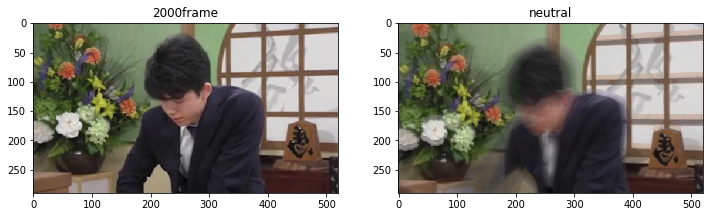

In [88]:
compare_plot([pose_rect, img_orig_mean], ["2000frame", "neutral"])

In [89]:
# 60手目ぐらいで実行
cap.set(cv2.CAP_PROP_POS_FRAMES, 30000)
frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
pose_rect = frame[220:510, 1340:1860].copy()

In [90]:
neutral_hash = imagehash.phash(Image.fromarray(np.uint8(img_orig_mean)))
now_hash = imagehash.phash(Image.fromarray(np.uint8(pose_rect)))

In [91]:
neutral_hash - now_hash

22

In [92]:
neutral_hash = imagehash.phash(Image.fromarray(np.uint8(img_skel_mean)))

pose_keypoints, scores = pose_detector(pose_rect)
img_skel = draw_person_pose(np.full_like(pose_rect, 255), pose_keypoints[np.where(scores > 5)])

now_hash = imagehash.phash(Image.fromarray(np.uint8(img_skel)))

/home/nvidia/Desktop/Research/utils/DeNAPose/pose_detector.py:147: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  paf_in_edge = np.hstack([paf[0][np.hsplit(integ_points, 2)], paf[1][np.hsplit(integ_points, 2)]])


In [93]:
neutral_hash - now_hash

12

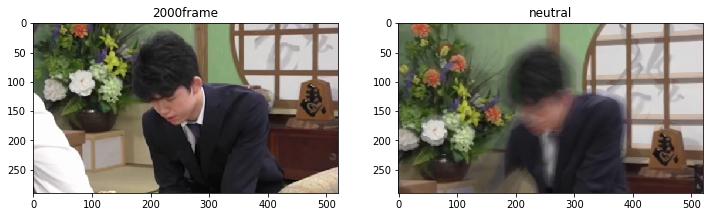

In [94]:
compare_plot([pose_rect, img_orig_mean], ["2000frame", "neutral"])

## perceptual hashでひとまずすべてのフレームに対して差をとって分布を見てみる。

In [103]:
print(cap.get(cv2.CAP_PROP_FRAME_COUNT) // 6)

10322.0


In [1]:
mean_flag = True
flag_prev, flag_next = True, True
isFujii = True # Falseなら後手
time_idx, hand_idx = 0, 0
threshold = 10
pose_thresh = 5

sampling_frame_rate = 60

pose_frames, hand_labels, times = [], [], []
orig_hash_list, skel_hash_list = [], []

cap = cv2.VideoCapture("/media/nvidia/JetsonTX2SSD240/data/AbemaTV_Tournament_Final1.mp4")
        
for i in tqdm(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//sampling_frame_rate)):
    cap.set(cv2.CAP_PROP_POS_FRAMES, sampling_frame_rate*i)

    frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
    pose_rect = frame[220:510, 1340:1860].copy()

    pose_frames.append(pose_rect)
    hand_labels.append(hand_idx)

    black_flag_rect = frame[475:630, 35:45].copy()
    white_flag_rect = frame[555:710, 1345:1355].copy()

    # 先手と後手が入れ替わったら
    if (flag_prev ^ flag_next) or i==0:
        b_mean_prev = np.mean(black_flag_rect, axis=(0, 1))
        w_mean_prev = np.mean(white_flag_rect, axis=(0, 1)) 
        flag_prev = flag_next
        continue

    # 先手もしくは後手が指し手を考慮中の場合
    else:
        b_mean_next = np.mean(black_flag_rect, axis=(0, 1))
        w_mean_next = np.mean(white_flag_rect, axis=(0, 1))

        if flag_prev:
            state = np.mean(b_mean_next - b_mean_prev)
            b_mean_prev = b_mean_next
        else:
            state = np.mean(w_mean_next - w_mean_prev)
            w_mean_prev = w_mean_next 

        if abs(state) > threshold:
            flag_next = not flag_next
            print("{}の指し手までの時間: {}s".format(["先手", "後手"][~flag_prev], (i - time_idx) * sampling_frame_rate//60))
            times.append((i - time_idx) * 0.1)
            time_idx = i
            hand_idx += 1

    # 10手指したらこれまでの画像の平均的な画像をオリジナルとスケルトンの2つで作成
    # 0.1秒ごとの画像が取れているのでそこから10分の1枚をサンプリングして使用
    if (hand_idx == threshold) and mean_flag:
        # sampling 
#         sampling_idx = [_ for _ in range(len(pose_frames)) if i%10==1]
#         sampling_pose_frames = np.array(pose_frames)[sampling_idx]
        
        for idx, img in enumerate(tqdm(pose_frames)):
            if idx==0:
                img_prev_orig = img

                pose_keypoints, scores = pose_detector(img)
                img_prev_skel = draw_person_pose(np.full_like(img, 255), pose_keypoints[np.where(scores > pose_thresh)])
                continue
            else:
                img_next_orig = img

                pose_keypoints, scores = pose_detector(img)
                img_next_skel = draw_person_pose(np.full_like(img, 255), pose_keypoints[np.where(scores > pose_thresh)])

                if idx==1:
                    img_orig_mean = cv2.addWeighted(img_prev_orig, 1 - (1/(idx+1)), img_next_orig, 1/(idx+1), 0)
                    img_skel_mean = cv2.addWeighted(img_prev_skel, 1 - (1/(idx+1)), img_next_skel, 1/(idx+1), 0)
                else:
                    img_orig_mean = cv2.addWeighted(img_orig_mean, 1 - (1/(idx+1)), img_next_orig, 1/(idx+1), 0)
                    img_skel_mean = cv2.addWeighted(img_skel_mean, 1 - (1/(idx+1)), img_next_skel, 1/(idx+1), 0)

        cv2.imwrite("../output/img_orig_mean.png", cv2.cvtColor(img_orig_mean, cv2.COLOR_RGB2BGR))
        cv2.imwrite("../output/img_skel_mean.png", cv2.cvtColor(img_skel_mean, cv2.COLOR_RGB2BGR))
        mean_flag = False

    #11手目からperceptual hashで差分を比較
    elif hand_idx > threshold:
        neutral_orig_hash = imagehash.phash(Image.fromarray(np.uint8(img_orig_mean)))
        now_orig_hash = imagehash.phash(Image.fromarray(np.uint8(black_flag_rect if isFujii else white_flag_rect)))

        neutral_skel_hash = imagehash.phash(Image.fromarray(np.uint8(img_skel_mean)))
        pose_keypoints, scores = pose_detector(pose_rect)
        img_skel = draw_person_pose(np.full_like(pose_rect, 255), pose_keypoints[np.where(scores > 5)])
        now_skel_hash = imagehash.phash(Image.fromarray(np.uint8(img_skel)))

        orig_hash_list.append(neutral_orig_hash - now_orig_hash)
        skel_hash_list.append(neutral_skel_hash - now_skel_hash)

NameError: name 'cv2' is not defined